# **Week2 복습과제**

**1. [ANN]**

**2. [CNN]**

- 데이터는 Week 1 과 같이 MNIST (0-9 숫자 분류) 데이터셋입니다.
- 이때, 우리의 복습과제에서는 0-4 숫자 분류를 위한 데이터 샘플만 사용할 예정입니다
- 아래 코드를 실행시켜 주세요

In [1]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, Subset
import random

# Tensor 변환을 위함
transform = transforms.Compose([
    transforms.ToTensor()
])

# MNIST 데이터셋 불러오기
train_dataset = MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = MNIST(root='./data', train=False, transform=transform, download=True)

# 무작위로 샘플 인덱스 선택
train_indices = [i for i, label in enumerate(train_dataset.targets) if label in [0, 1, 2, 3, 4]]
test_indices = [i for i, label in enumerate(test_dataset.targets) if label in [0, 1, 2, 3, 4]]

# Subset을 사용하여 샘플링된 데이터셋 생성
train_subset = Subset(train_dataset, train_indices)
test_subset = Subset(test_dataset, test_indices)


# DataLoader 생성
batch_size = 64  # 배치 크기는 64로 설정 (batch_size를 다르게 실행해보셔도 좋습니다)
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False)

100%|██████████| 9.91M/9.91M [00:00<00:00, 16.1MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 479kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.44MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.46MB/s]


In [2]:
# 데이터셋 크기 확인을 위해 해당 셀을 실행시켜 주세요
print(f"Train dataset size: {len(train_subset)}")
print(f"Test dataset size: {len(test_subset)}")

Train dataset size: 30596
Test dataset size: 5139


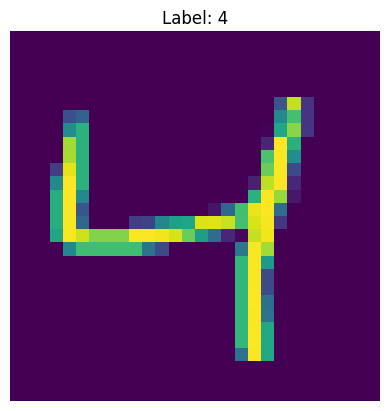

In [3]:
# 데이터셋 중 하나의 이미지를 시각화해보기
import matplotlib.pyplot as plt
import numpy as np

# 데이터셋에서 하나의 샘플 가져오기
image, label = train_subset[1]

# 텐서를 NumPy 배열로 변환
image = image.numpy().squeeze()

# 이미지 출력
plt.imshow(image)  # 이미지 표시
plt.title(f"Label: {label}")  # 레이블 표시
plt.axis("off")  # 축 없애기
plt.show()

<a id="1"></a> <br>
## **1. ANN**

**인공 신경망 (ANN)**

>  로지스틱 회귀는 분류 문제에서 성능이 좋지만, 데이터의 비선형성이 증가하면 모델의 정확도가 감소합니다.

>  따라서, hidden lyaer 에 더 많은 비선형 함수를 추가시켜 모델의 복잡도를 증가시켜 봅시다. 😀

↪ **3개의 hidden layer를 쌓고 다양한 활성화 함수 ReLU, Tanh, ELU 사용해봅시다**


In [4]:
# 필요한 라이브러리 임포트
import torch
import torch.nn as nn

#### **ANN 모델 생성**

In [5]:
# ANN Model
class ANNModel(nn.Module):

    def __init__(self, input_dim, hidden_dim, output_dim):
        super(ANNModel, self).__init__()

        # Linear function 1: 입력층 --> 은닉층1  (입력 차원에서 숨겨진 계층으로)
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        # Non-linearity 1 (ReLU 활성화 함수)
        self.relu1 = nn.ReLU()

        # Linear function 2: 은닉층1 --> 은닉층2  (숨겨진 계층을 한 번 더 통과)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        # Non-linearity 2 (Tanh 활성화 함수 사용)
        self.tanh2 = nn.Tanh()

        # Linear function 3: 은닉층2 --> 은닉층3  (추가 숨겨진 계층)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        # Non-linearity 3 (ELU 활성화 함수)
        self.elu3 = nn.ELU()

        # Linear function 4: 은닉층3 --> 출력층  (마지막 출력층)
        self.fc4 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Linear function 1
        out = self.fc1(x)
        # Non-linearity 1
        out = self.relu1(out)

        # Linear function 2
        out = self.fc2(out)
        # Non-linearity 2
        out = self.tanh2(out)

        # Linear function 3
        out = self.fc3(out)
        # Non-linearity 3
        out = self.elu3(out)

        # Linear function 4
        out = self.fc4(out)  # 마지막 출력층
        return out

In [6]:
# ANN 객체 생성
input_dim = 28*28  # 이미지 크기 (28x28)
hidden_dim = 150  # 하이퍼파라미터 (150으로 설정)
output_dim = 5  # 출력 클래스 개수 (0~4)


model = ANNModel(input_dim, hidden_dim, output_dim)
# 손실 함수 설정
loss_ftn = nn.CrossEntropyLoss() # 다중분류에 적합한 손실함수를 선택해주세요

# SGD Optimizer 사용 - 다른 옵티마이저를 사용해보셔도 됩니다 :)
learning_rate = 0.02
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

#### **ANN 모델 학습**

In [7]:
# ANN 모델 학습

# 학습을 모니터링하기 위한 변수들
count = 0  # 반복 횟수
loss_list = []  # Loss 저장 리스트
iteration_list = []  # Iteration 저장 리스트
accuracy_list = []  # 정확도 저장 리스트

# 전체 학습
for epoch in range(10):

    # 배치 단위 학습
    for i, (images, labels) in enumerate(train_loader):

        # 데이터를 모델 입력 형태로 변환 (2D 텐서로 펼치기)
        train = images.view(-1, 784)  # 28x28 이미지를 펼쳐서 1D 벡터로 변환
        labels = labels  # 텐서 형태 유지

        # 옵티마이저의 기울기 초기화
        optimizer.zero_grad()

        # Forward
        # 모델을 이용해 예측값(outputs) 계산
        outputs = model(train)

        # 손실 계산
        # cross entropy loss를 사용해 예측값과 실제값 비교
        loss = loss_ftn(outputs, labels)

        # Backward propagation - 손실에 대한 기울기 계산
        loss.backward()

        # 가중치 업데이트
        optimizer.step()

        count += 1  # 반복 횟수 증가

        if count % 50 == 0:
            # 정확도 계산을 위한 변수 초기화
            correct = 0
            total = 0


            # 모델이 테스트 데이터셋에서 얼마나 잘 예측하는지 확인
            for images, labels in test_loader:

                test = images.view(-1, 784)  # 28x28 이미지를 펼쳐서 1D 벡터로 변환
                # Forward
                # 예측값 계산
                outputs = model(test)

                # 예측값 중 가장 높은 값을 선택
                predicted = torch.max(outputs.data, 1)[1]

                # 총 샘플 개수
                total += len(labels)

                # 올바르게 예측한 개수
                correct += (predicted == labels).sum()

            # 정확도 계산
            accuracy = 100 * correct / float(total)

            # 손실 및 정확도 저장
            loss_list.append(loss.item())
            iteration_list.append(count)
            accuracy_list.append(accuracy)

        if count % 500 == 0:
            # 손실 및 정확도 출력
            print('Iteration: {}  Loss: {}  Accuracy: {} %'.format(count, loss.data, accuracy))


Iteration: 500  Loss: 0.2199508100748062  Accuracy: 96.08872985839844 %
Iteration: 1000  Loss: 0.12484348565340042  Accuracy: 97.1978988647461 %
Iteration: 1500  Loss: 0.13609856367111206  Accuracy: 97.56761932373047 %
Iteration: 2000  Loss: 0.14754638075828552  Accuracy: 97.68437194824219 %
Iteration: 2500  Loss: 0.09082537144422531  Accuracy: 97.89842224121094 %
Iteration: 3000  Loss: 0.018580634146928787  Accuracy: 97.93733978271484 %
Iteration: 3500  Loss: 0.09675606340169907  Accuracy: 98.1319351196289 %
Iteration: 4000  Loss: 0.03587176650762558  Accuracy: 98.32652282714844 %
Iteration: 4500  Loss: 0.021817736327648163  Accuracy: 98.48219299316406 %


#### **ANN 학습 결과**

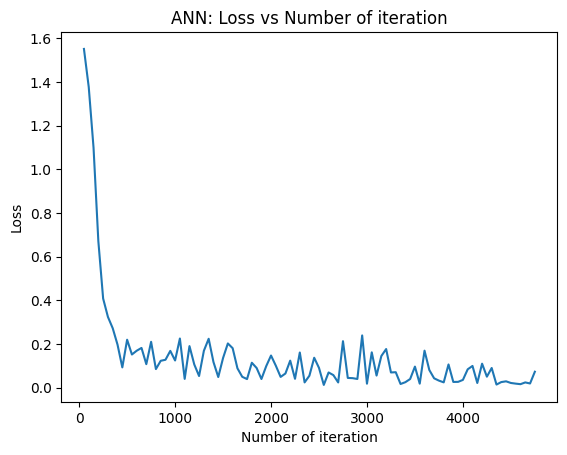

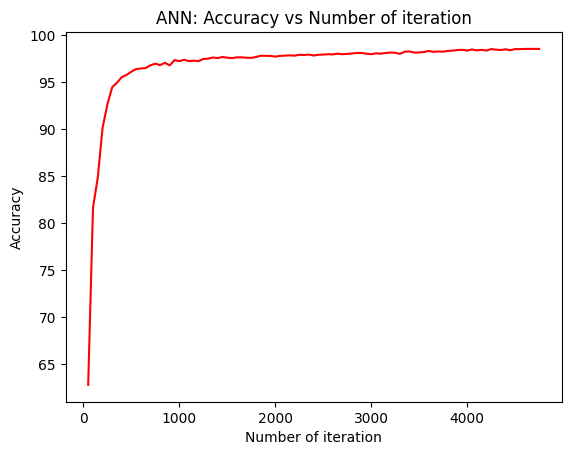

In [8]:
# loss 시각화
plt.plot(iteration_list,loss_list)
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.title("ANN: Loss vs Number of iteration")
plt.show()

# accuracy 시각화
plt.plot(iteration_list,accuracy_list,color = "red")
plt.xlabel("Number of iteration")
plt.ylabel("Accuracy")
plt.title("ANN: Accuracy vs Number of iteration")
plt.show()

**해당 셀의 마크 다운을 풀고 시각화된 모델의 학습 결과를 해석해주세요.** 🤗



---
**[해석]**
학습을 진행할수록 손실값은 작아지고, 정확도는 상승하고 있다(학습이 잘 되고 있다)

#### **ANN 최적의 하이퍼파라미터 찾기**

1️⃣ **실험 1: Hidden Dimension 최적값 찾기**
- hidden_dim 값을 50-200 사이 값들로 설정하고 모델을 학습
- 각 hidden_dim 값에 대해 학습을 수행하면서 loss과 accuracy를 저장
- 모든 결과를 한 그래프에 표시하여 비교




2️⃣ **실험 2: Learning Rate 최적값 찾기**

- learning_rate 값을 0.1-0.005 사이 값들로 설정하고 모델을 학습
- 각 learning_rate 값에 대해 학습을 수행하면서 loss과 accuracy를 저장
- 모든 결과를 한 그래프에 표시하여 비교



**⚠ 이때 epoch 값은 자유롭게 해주셔도 됩니다! **

In [9]:
# 실험 1: hidden_dim 값을 [50, 100, 150, 200]으로 설정해 학습

input_size = 28 * 28  # 입력 크기 (MNIST 이미지: 28x28)
hidden_layer_sizes = [50, 100, 150, 200]  # 다양한 hidden layer 크기
output_size = 5  # 분류할 클래스 수 (0~4)

# 결과 저장용 딕셔너리
results = {}

# hidden layer 크기별로 학습 반복
for hidden_size in hidden_layer_sizes:
    model = ANNModel(input_size, hidden_size, output_size)

    # 손실 함수 및 옵티마이저 설정
    criterion = nn.CrossEntropyLoss()
    lr = 0.02
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)

    # 학습 상태 저장용 리스트
    step = 0
    loss_history = []
    step_history = []
    acc_history = []

    # 에폭 반복
    for epoch in range(10):
        for batch_images, batch_labels in train_loader:
            # 입력 데이터 전처리: 2D -> 1D 벡터
            inputs = batch_images.view(-1, input_size)
            targets = batch_labels

            # 그래디언트 초기화
            optimizer.zero_grad()

            # 순전파
            predictions = model(inputs)

            # 손실 계산
            loss = criterion(predictions, targets)

            # 역전파 및 가중치 업데이트
            loss.backward()
            optimizer.step()

            step += 1

            # 일정 간격마다 정확도 측정
            if step % 50 == 0:
                total = 0
                correct = 0

                with torch.no_grad():
                    for test_imgs, test_labels in test_loader:
                        test_inputs = test_imgs.view(-1, input_size)
                        test_outputs = model(test_inputs)
                        predicted_labels = torch.argmax(test_outputs, dim=1)
                        total += test_labels.size(0)
                        correct += (predicted_labels == test_labels).sum().item()

                accuracy = 100 * correct / total

                # 결과 저장
                loss_history.append(loss.item())
                step_history.append(step)
                acc_history.append(accuracy)

    # 현재 hidden_size에 대한 결과 저장
    results[hidden_size] = (loss_history, acc_history)


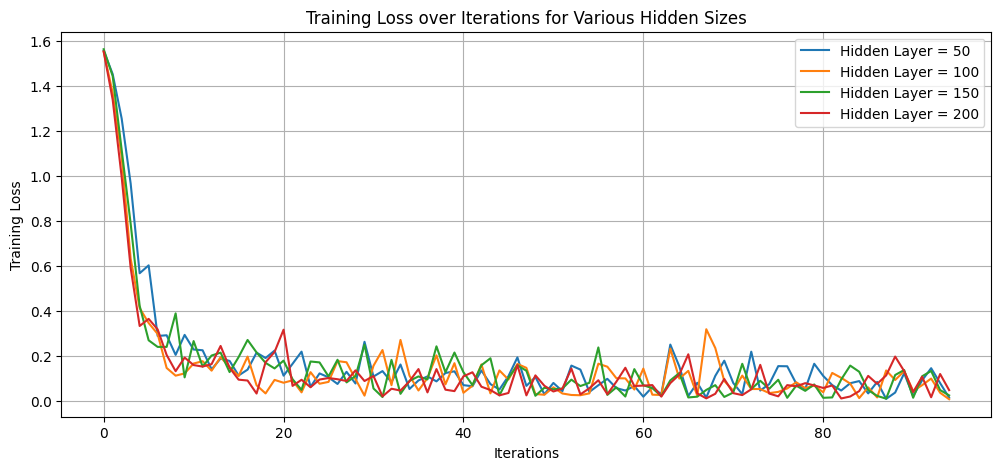

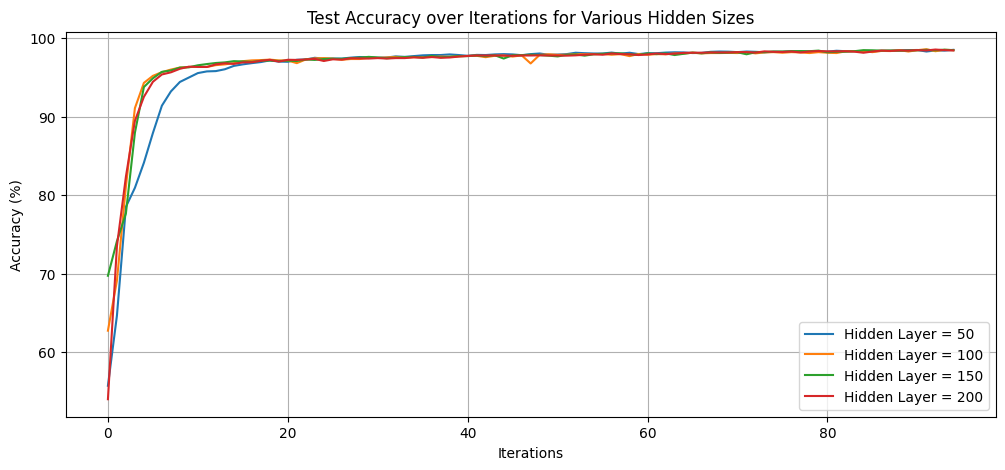

In [10]:
# 실험 1 모델 학습 결과 시각화

import matplotlib.pyplot as plt

# 손실 그래프
plt.figure(figsize=(12, 5))
for h in hidden_layer_sizes:
    loss_values = results[h][0]
    plt.plot(loss_values, label=f'Hidden Layer = {h}')
plt.xlabel('Iterations')
plt.ylabel('Training Loss')
plt.title('Training Loss over Iterations for Various Hidden Sizes')
plt.legend()
plt.grid(True)
plt.show()

# 정확도 그래프
plt.figure(figsize=(12, 5))
for h in hidden_layer_sizes:
    acc_values = results[h][1]
    plt.plot(acc_values, label=f'Hidden Layer = {h}')
plt.xlabel('Iterations')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy over Iterations for Various Hidden Sizes')
plt.legend()
plt.grid(True)
plt.show()


**해당 셀의 마크 다운을 풀고 hidden dimension 값이 모델의 학습에 주는 영향을 설명해주세요.** 🤗



---
**[답변]**
히든 레이어가 많아질수록(=모델이 깊어질수록) 일반적으로 성능이 향상된다.
이때 너무 깊어질 경우 과적합이 발생할 수 있지만, 지금의 그래프상으로는 큰 차이를 확인하기는 어렵다.

In [12]:
# 실험 2: 다양한 학습률(learning rate)에 따른 모델 성능 비교

input_size = 28 * 28  # MNIST 이미지 (28x28) -> 1D 벡터
hidden_size = 150     # 은닉층 크기 고정
output_size = 5       # 클래스 수 (0~4)

learning_rates = [0.1, 0.05, 0.005]  # 실험할 학습률 리스트

# 결과 저장 딕셔너리
results = {}

# 각 learning rate 별로 모델 학습
for lr in learning_rates:
    model = ANNModel(input_size, hidden_size, output_size)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)

    # 학습 과정 기록용 리스트
    step = 0
    loss_history = []
    step_history = []
    acc_history = []

    for epoch in range(10):
        for batch_images, batch_labels in train_loader:
            inputs = batch_images.view(-1, input_size)
            targets = batch_labels

            optimizer.zero_grad()
            predictions = model(inputs)
            loss = criterion(predictions, targets)
            loss.backward()
            optimizer.step()

            step += 1

            if step % 50 == 0:
                correct = 0
                total = 0

                with torch.no_grad():
                    for test_imgs, test_labels in test_loader:
                        test_inputs = test_imgs.view(-1, input_size)
                        test_outputs = model(test_inputs)
                        predicted = torch.argmax(test_outputs, dim=1)
                        total += test_labels.size(0)
                        correct += (predicted == test_labels).sum().item()

                acc = 100 * correct / total
                loss_history.append(loss.item())
                step_history.append(step)
                acc_history.append(acc)

    results[lr] = (loss_history, acc_history)


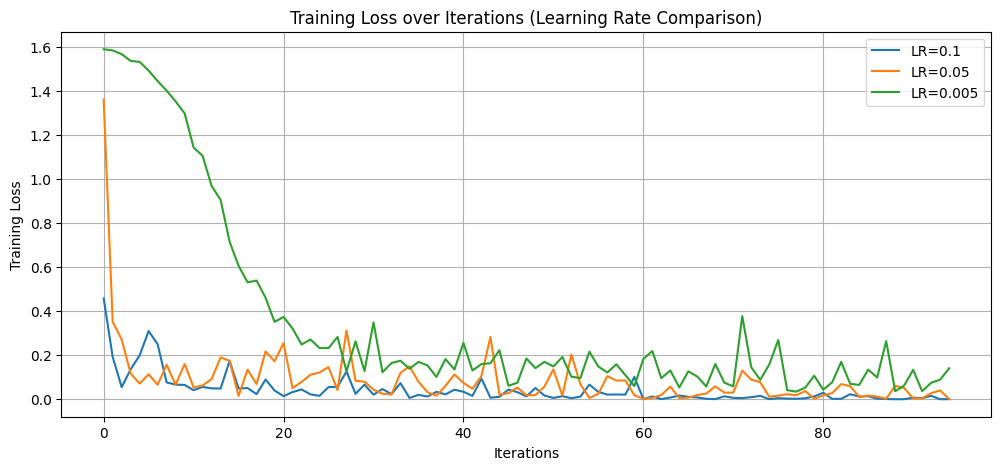

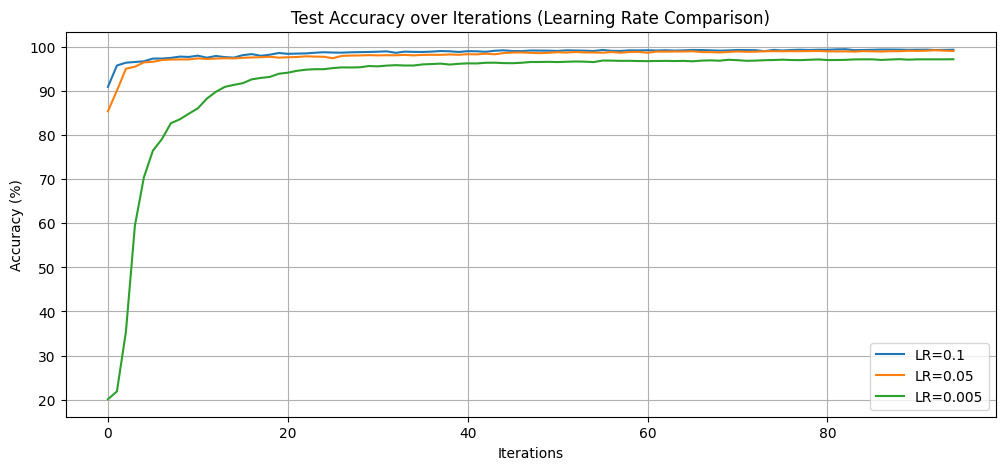

In [13]:
# 실험 2 모델 학습 결과 시각화

plt.figure(figsize=(12, 5))
for lr in learning_rates:
    losses = results[lr][0]
    plt.plot(losses, label=f'LR={lr}')
plt.xlabel('Iterations')
plt.ylabel('Training Loss')
plt.title('Training Loss over Iterations (Learning Rate Comparison)')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 5))
for lr in learning_rates:
    accs = results[lr][1]
    plt.plot(accs, label=f'LR={lr}')
plt.xlabel('Iterations')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy over Iterations (Learning Rate Comparison)')
plt.legend()
plt.grid(True)
plt.show()

**해당 셀의 마크 다운을 풀고 learning rate 값이 모델의 학습에 주는 영향을 설명해주세요.** 🤗



---
**[답변]**
- lr 값이 너무 작은 경우, 학습이 오래 걸릴 수 있다. (최적점까지 너무 조금씩 이동)
- lr 값이 반대로 너무 큰 경우, 제대로 학습되지 않고 발산해버릴 수 있다.

<a id="1"></a> <br>
## **2. CNN**
> CNN은 이미지 분류에 적합한 모델로, kernel을 이용해 feature map을 생성합니다

**↪ 2개의 합성곱 계층을 쌓고, 활성화 함수로 ReLU를 사용하며,Max Pooling layer를 적용해봅시다.**

#### **CNN 모델 생성**

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim

# CNN Model 정의
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()

        # 합성곱 계층 1 (Conv Layer 1)
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=0)
        self.relu1 = nn.ReLU()  # 활성화 함수 (ReLU)

        # Max Pooling 1
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)  # kernel size를 2로 설정

        # 합성곱 계층 2 (Conv Layer 2)
        self.cnn2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=0)
        self.relu2 = nn.ReLU()  # 활성화 함수 (ReLU)

        # Max Pooling 2
        self.maxpool2 = nn.MaxPool2d(kernel_size=2) # kernel size를 2로 설정

        # Fully Connected Layer
        self.fc1 = nn.Linear(32 * 4 * 4, 5)  # 입력 차원 및 출력 차원 지정

    def forward(self, x):
        # 합성곱 계층 1 + 활성화 함수
        out = self.cnn1(x)
        out = self.relu1(out)

        # Max Pooling 1
        out = self.maxpool1(out)

        # 합성곱 계층 2 + 활성화 함수
        out = self.cnn2(out)
        out = self.relu2(out)

        # Max Pooling 2
        out = self.maxpool2(out)

        # feature map을 flatten하게
        out = out.view(out.size(0), -1)

        # 완전 연결 계층
        out = self.fc1(out)

        return out


In [15]:
# CNN 객체 생성
model = CNNModel()
# 손실 함수 설정
loss_ftn = nn.CrossEntropyLoss()  # 다중분류에 적합한 손실함수를 선택해주세요

# SGD Optimizer 사용 - 다른 옵티마이저를 사용해보셔도 됩니다 :)
optimizer = optim.SGD(model.parameters(), lr=0.01)  # 학습률을 자유롭게 설정해주세요

#### **CNN 모델 학습**

In [18]:
# CNN 모델 학습

# 학습을 모니터링하기 위한 변수들
count = 0  # 반복 횟수
loss_list = []  # Loss 저장 리스트
iteration_list = []  # Iteration 저장 리스트
accuracy_list = []  # 정확도 저장 리스트
num_epochs = 10  # 학습할 에포크 수 설정 -> 자유롭게 설정해주셔도 됩니다

for epoch in range(num_epochs):
    running_loss = 0.0  # 에포크별 손실 초기화

    for images, labels in train_loader:
        # 옵티마이저의 기울기 초기화
        optimizer.zero_grad()

        # Forward
        outputs = model(images)

        # 손실 계산
        loss = loss_ftn(outputs, labels)

        # Backward
        loss.backward

        # 가중치 업데이트
        optimizer.step()

        # 손실 누적
        running_loss += loss.item()
        count += 1  # 반복 횟수 증가

        if count % 50 == 0:
            correct = 0
            total = 0

            with torch.no_grad():  # 평가
                for images, labels in test_loader:
                    # 모델 예측 수행
                    outputs = model(images)

                    # 가장 확률이 높은 클래스 선택
                    predicted = torch.max(outputs.data,1)[1]

                    # 총 샘플 수 및 올바른 예측 개수 누적
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()

            # 정확도 계산
            accuracy = 100 * correct / float(total)

            # 손실 및 정확도 저장
            loss_list.append(loss.item())
            iteration_list.append(count)
            accuracy_list.append(accuracy)

    # 매 에포크마다 평균 손실 출력
    print(f"Epoch {epoch+1}, Loss: {running_loss / len(train_loader)}")

Epoch 1, Loss: 1.618786663501397
Epoch 2, Loss: 1.6188424935171648
Epoch 3, Loss: 1.6188635261173288
Epoch 4, Loss: 1.6189722347856812
Epoch 5, Loss: 1.6187353417868404
Epoch 6, Loss: 1.618789950094044
Epoch 7, Loss: 1.6189428789381692
Epoch 8, Loss: 1.6186547523251655
Epoch 9, Loss: 1.619000015776441
Epoch 10, Loss: 1.6188854785453302


#### **CNN 학습 결과**

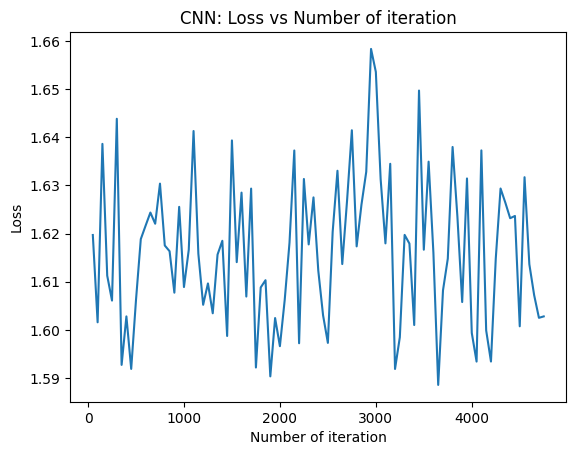

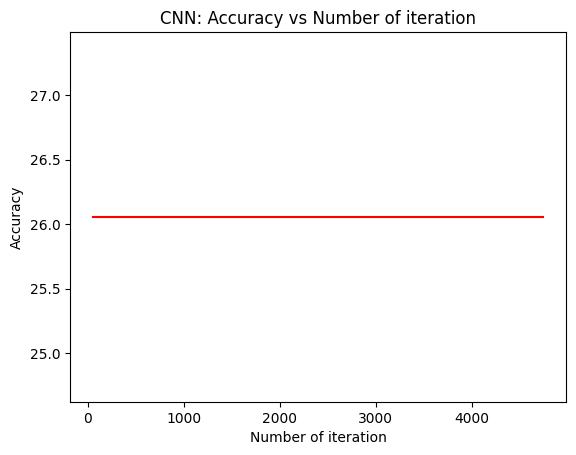

In [19]:
# loss 시각화
plt.plot(iteration_list,loss_list)
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.title("CNN: Loss vs Number of iteration")
plt.show()

# accuracy 시각화
plt.plot(iteration_list,accuracy_list,color = "red")
plt.xlabel("Number of iteration")
plt.ylabel("Accuracy")
plt.title("CNN: Accuracy vs Number of iteration")
plt.show()

**해당 셀의 마크 다운을 풀고 MNIST 데이터셋에서 ANN, CNN의 학습 결과 비교와 함께 두 모델에 대해 각각 짧게 소개해주세요.** 🤗



---
**[답변]**
- ANN은 단순하게 Linear layer와 활성화 함수를 교차로 쌓은 것으로, 이미지의 공간적 구조를 충분히 반영하지 못한다.
- CNN은 이미지 처리에 특화된 모델로, convolution 연산을 활용하여 이미지의 공간적 구조를 보존하면서 데이터를 처리한다.
